In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sortedcontainers import SortedDict


In [175]:
def PrintSortDict(sd):
    for k in sd.keys():
        print(f"{k}: {sd[k]}")

def PrintScope(sd):
    for k in sd.keys():
        print(f"Vizinhos de {k.id}: ")
        for kk in sd[k].keys():
            print(f"{kk.id}: {sd[k][kk]}")

In [176]:
class Point:
    id = 1
    def __init__(self,a,b, c = 0, shake=1e-5):
        self.id = Point.id
        Point.id+=1
        shakes = np.random.uniform(-shake, shake, 2)
        self.x = a+shakes[0]
        self.y = b+shakes[1]
        self.classe = c

    def __add__(self, other):
        if isinstance(other, Point):
            return Point(self.x+other.x, self.y+other.y)
        else:
            raise TypeError("Unsupported operand type")
        
    def __sub__(self, other):
        if isinstance(other, Point):
            return Point(self.x-other.x, self.y-other.y)
        else:
            raise TypeError("Unsupported operand type")
        
    def __str__(self):
        return str(self.id)+": "+str(self.x)+"   "+str(self.y)
    
    def __lt__(self,other):
        if isinstance(other, Point):
            vec_prod = (self.x*other.y)-(self.y*other.x)
            if vec_prod>0:
                return True
            elif vec_prod<0:
                return False
            else:
                raise Exception("Segments are parallel")
        else:
            raise TypeError("Unsupported operand type")
        
    def Reset():
        Point.id = 1

def X_Coord(point):
    return point.x

In [177]:
class Segment:
    id = 1
    def __init__(self,a: Point, b: Point, shake_seg = 0):
        if b.x<a.x:
            temp = a
            a = b
            b = temp
        self.bgn = a+Point(0,0,shake=shake_seg)
        self.end = b+Point(0,0,shake=shake_seg)
        self.slope = (self.end.y-self.bgn.y)/(self.end.x-self.bgn.x)
        self.intercept = self.end.y - (self.slope * self.end.x)
        self.id = Segment.id
        Segment.id+=1
        
    
    def Y_At_X(self,x):
        return self.slope*x+self.intercept


    def Invert(self):
        temp = self.bgn
        self.bgn = self.end
        self.end = temp

    def __str__(self):
        return "Id: "+str(self.id)+"\nBegin: "+str(self.bgn.x)+"   "+str(self.bgn.y)+"\nEnd: "+str(self.end.x)+"   "+str(self.end.y)
    
    def __lt__(self,other):
        if isinstance(other, Segment):
            return self.bgn.x < other.bgn.x
        else:
            raise TypeError("Unsupported operand type")
        
    def Reset():
        Segment.id = 1

In [178]:
class LimitPoint:
    def __init__(self,p,i):
        self.point = p
        self.is_end = i

    def __lt__(self,other):
        if isinstance(other, LimitPoint):
            return self.point.x < other.point.x
        else:
            raise TypeError("Unsupported operand type")

## Primitivas

In [179]:
def Clockwise(a: Segment, b: Segment): #returns true if a is clockwise to b
    frst_seg = a.end - a.bgn
    scnd_seg = b.end - b.bgn
    vec_prod = (frst_seg.x*scnd_seg.y)-(frst_seg.y*scnd_seg.x)
    if vec_prod>0:
        return True
    elif vec_prod<0:
        return False
    else:
        raise Exception("Segments are parallel")

In [180]:
def SegmentsIntercept(a: Segment,b: Segment):
    check_one = Clockwise(a,Segment(a.bgn,b.bgn))
    check_two = Clockwise(a,Segment(a.bgn,b.end))
    if check_one==check_two:
        return False
    check_one = Clockwise(b,Segment(b.bgn,a.bgn))
    check_two = Clockwise(b,Segment(b.bgn,a.end))
    if check_one==check_two:
        return False
    return True

## Data reading and pre-processing

In [181]:
def SetTwoDimensions(df):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = pca_result, columns = ['x', 'y'])
    return df_pca

In [182]:
def PreProcessData(path, tgtCol):
    df = pd.read_csv(path)
    tgtData = df.iloc[:, tgtCol]  # Save the nth column
    df = df.drop(df.columns[tgtCol], axis=1)
    df = SetTwoDimensions(df)
    df['target_data'] = tgtData
    return df

In [183]:
def ExtractPoints(df):
    rb_tree_points = SortedDict(X_Coord)
    for i in range(len(df)):
        p = Point(df.loc[i, "x"], df.loc[i, "y"], df.loc[i,"target_data"])
        rb_tree_points[p] = None
    return rb_tree_points


In [184]:
def ReadData(path, tgtCol):
    df = PreProcessData(path, tgtCol)
    rb_tree_points = ExtractPoints(df)
    return rb_tree_points


## Convex Hull

In [185]:
def print_convex_hull(hull,points):
    polar_hull = SortedDict()
    for key in hull.keys():
        polar_hull[key] = None

    keys = list(polar_hull.keys())
    x = []
    y = []
    for key in polar_hull.keys():
        x.append(key.x)
        y.append(key.y)
    x.append(x[0])
    y.append(y[0])

    ps = []
    for p in points.items():
        ps.append(p[0])
    xs = list(map(lambda p:p.x,ps))
    ys = list(map(lambda p:p.y,ps))

    plt.plot(x,y)
    plt.scatter(xs,ys)
    plt.show()

In [186]:
def ConvexHull(rb_tree_points):
    hull_points = SortedDict(lambda p:p.x)

    p0 = rb_tree_points.peekitem(0)[0]
    p1 = rb_tree_points.peekitem(1)[0]
    p2 = rb_tree_points.peekitem(2)[0]

    hull_points[p0] = None
    hull_points[p1] = None
    hull_points[p2] = None
    
    print_convex_hull(hull_points,rb_tree_points)

    it_points = list(rb_tree_points.keys())
    for p in it_points[3:]:
        j = -1
        
        #Update upper bound
        u = j
        p_i_m1 = (j-1) % len(hull_points)
        
        while(Clockwise(
                        Segment(hull_points.items()[p_i_m1][0],p),
                        Segment(hull_points.items()[p_i_m1][0],hull_points.items()[u][0])
                        )):
            if(u != j):
                hull_points.pop(hull_points.items()[u][0])
            u = (u-1)%len(hull_points)
            p_i_m1 = (u-1)%len(hull_points)
        
        #Update lower bound
        l = 0
        p_i_p2 = (l+1) % len(hull_points)

        while(Clockwise(
                        Segment(p,hull_points.items()[l][0]),
                        Segment(p,hull_points.items()[p_i_p2][0])
                        )
            ):
            if(l != u):
                hull_points.pop(hull_points.items()[l][0])
            l = (l+1)%len(hull_points)
            p_i_p2 = (l+1)%len(hull_points)
        
        # Necessário encontrar uma função que insira o ponto em uma posição específica do ponto
        hull_points[p] = None
        print_convex_hull(hull_points,rb_tree_points)
    return hull_points

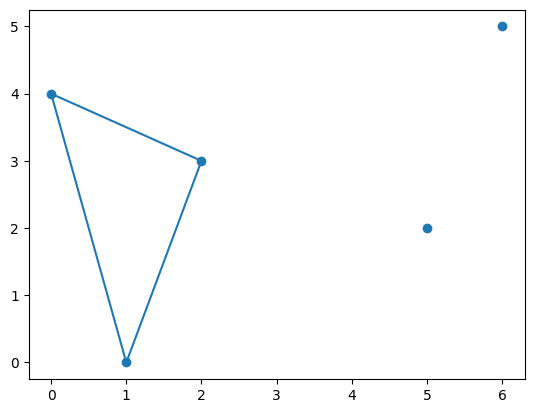

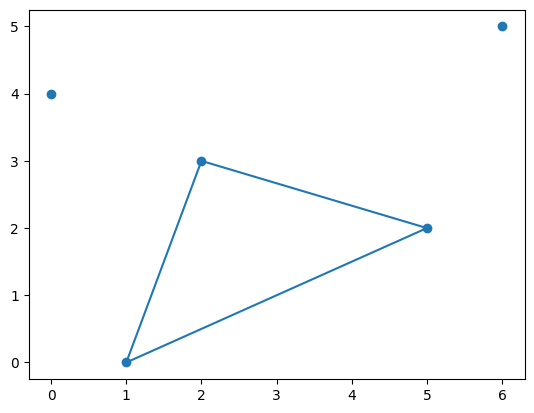

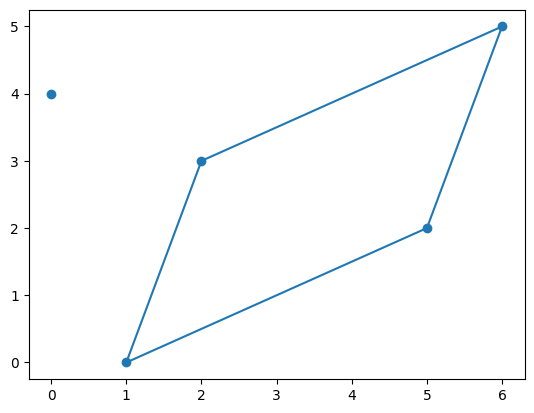

In [187]:
import matplotlib.pyplot as plt
rbt = SortedDict(lambda p: p.x)
#Test convex hull
p1 = Point(1,0)
p2 = Point(2,3)
p3 = Point(5,2)
p4 = Point(6,5)
p5 = Point(0,4)

rbt[p1] = None
rbt[p2] = None
rbt[p3] = None
rbt[p4] = None
rbt[p5] = None

ch = ConvexHull(rbt)

## Sweep Line

In [142]:
def GetSegments(convex_hull):
    polar_hull = SortedDict()
    for key in convex_hull.keys():
        polar_hull[key] = None
    n = len(polar_hull)
    keys = list(polar_hull.keys())
    segments_hull = SortedDict()
    count = 0
    for key in polar_hull.keys():
        next_key = keys[(count + 1) % n]
        s = Segment(key,next_key,shake_seg=1e-5)
        count+=1
        segments_hull[s.bgn.x] = (s,0)
        segments_hull[s.end.x] = (s,1)
    return segments_hull

In [165]:
def SweepLine(segment_hull_one, segments_hull_two):
    segments_set = segment_hull_one.copy()
    segments_set.update(segments_hull_two)
    scope = SortedDict()
    for key in segments_set.keys():
        print(key)
        current_segment, end = segments_set[key]
        if not end: #início do segmento
            #print(f"Início do segmento {current_segment.id}")
            comparisons = dict()
            for comparable_segment in scope.keys():
                aux = (current_segment.bgn.y>comparable_segment.Y_At_X(key))
                comparisons[comparable_segment] = aux
                scope[comparable_segment][current_segment] = not aux
            scope[current_segment] = comparisons
            
        else:                          #fim do segmento
            #print(f"Fim do segmento {current_segment.id}")
            comparisons = scope[current_segment]
            del scope[current_segment]
            for comparable_segment in scope.keys():
                aux = (current_segment.end.y>comparable_segment.Y_At_X(key))
                if comparisons[comparable_segment] != aux:
                    return True
            
    return False

## Display

## Testing

In [79]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
Point.Reset()
polar_set = SortedDict()      #Points are being sorted according to polar coordinate
polar_set[p1] = None
polar_set[p2] = None
polar_set[p3] = None
for key in polar_set.keys():
    print(key)

1: 1.0   0.0
3: 2.0   2.0
2: 0.0   2.0


In [80]:
Point.Reset()
p1 = Point(1,0, shake=0)
p2 = Point(0,2, shake=0)
p3 = Point(2,2, shake=0)
p4 = Point(2,3, shake=0)
p5 = Point(1.5,3, shake=0)
p6 = Point(0.003,3, shake=0)
Point.Reset()
xc_set = SortedDict(X_Coord)      #Points are being sorted according to x coordinate
xc_set[p1] = None
xc_set[p2] = None
xc_set[p3] = None
xc_set[p4] = None
xc_set[p5] = None
xc_set[p6] = None
for key in xc_set.keys():
    print(key)

2: 0.0   2.0
6: 0.003   3.0
1: 1.0   0.0
5: 1.5   3.0
3: 2.0   2.0
4: 2.0   3.0


In [145]:
Segment.Reset()
Point.Reset()
p1 = Point(-1,0)
p2 = Point(1,0)
p3 = Point(-2,1)
p4 = Point(2,1)
p5 = Point(0,3)
pentagon = SortedDict()
pentagon[p1] = None
pentagon[p2] = None
pentagon[p3] = None
pentagon[p4] = None
pentagon[p5] = None
pentagon_seg = GetSegments(pentagon)       #working
for k in pentagon_seg.keys():
    if pentagon_seg[k][1]==0:
        print(pentagon_seg[k][0])
    print("\n")

Id: 5
Begin: -2.0000001853967655   0.9999908526583813
End: -0.9999838260520815   -5.493469204027943e-06


Id: 4
Begin: -1.9999930095598515   0.9999893152668412
End: -3.4824992375555102e-06   3.00000464727971


Id: 1
Begin: -1.0000153783066725   -9.294293234959443e-06
End: 1.000013058584532   -1.664675169613616e-05






Id: 3
Begin: 7.971588378259897e-06   2.9999967743526152
End: 1.999998538813313   0.9999888501374778




Id: 2
Begin: 1.0000167720674396   -1.8775809054160617e-05
End: 2.0000057357458787   1.0000009135154173








In [146]:
Point.Reset()
p1 = Point(0,2)
p2 = Point(3,0)
p3 = Point(3,3)
triangle = SortedDict()
triangle[p1] = None
triangle[p2] = None
triangle[p3] = None
triangle_seg = GetSegments(triangle)
for k in triangle_seg.keys():
    if triangle_seg[k][1]==0:
        print(triangle_seg[k][0])
    print("\n")


Id: 7
Begin: 1.1332436466519476e-05   2.0000028922962976
End: 3.000002588927641   2.9999944839766863


Id: 8
Begin: 1.982111759750059e-05   2.000001640587854
End: 3.0000176817479405   9.110486782002884e-06


Id: 6
Begin: 2.9999930460485165   2.9999905812495857
End: 2.9999995784460975   2.0784258268795032e-05










In [164]:
SweepLine(triangle_seg,pentagon_seg)

-2.0000001853967655
Início do segmento 5
-1.9999930095598515
Início do segmento 4
-1.0000153783066725
Início do segmento 1
-0.9999838260520815
Fim do segmento 5
-3.4824992375555102e-06
Fim do segmento 4
7.971588378259897e-06
Início do segmento 3
1.1332436466519476e-05
Início do segmento 7
1.982111759750059e-05
Início do segmento 8
1.000013058584532
Fim do segmento 1
1.0000167720674396
Início do segmento 2
1.999998538813313
Fim do segmento 3


True

In [30]:
for i in vec_s:
    print(i)

2: 2.999997913822665   1.0000081665137703
4: 2.000008793410377   1.0000003650231482
3: 1.999999953488618   1.999990186458855
1: 0.9999948015166591   1.9999901810797924
